In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2, warning
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [10]:
#fol = '/home/alessio/m-dynamicshere/results'
fol = '/home/alessio/Desktop/a-3dScanSashaSupport/n-Propagation/results'
fol = '/home/alessio/Desktop/Noise_Or_Not'
#fol = '.'
subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> VISUALIZE_NACS
1 -> b-pulseAlongX_0.22_0000
2 -> f-doublePulseXandZ_pi_phase_z_0000
3 -> g-pulseAlongX_Y_0.23_0000
4 -> h-pulsePolarizedx_y_0.25_0000
5 -> h-pulsePolarizedx_y_0.27_0000
6 -> m-only_IR_longer_with_nac_2_1_0000
7 -> m-only_IR_xy_0000
8 -> m-only_IR_xy_Longer_0000
9 -> o-fromS1withoutPulseNewGamma_0000
10 -> pulse22_x
11 -> w-from6withouspulse_0000
12 -> z-from3withouspulse_0000
13 -> z2-fromreal3withouspulse_0000
14 -> z2-fromreal3withouspulse_nac_21_0000
15 -> zz-from2withouspulse_0000
16 -> zzz-from1withoutpulse_0000



In [11]:
interactive = True
subfolder = subfolders[6]
#subfolder = subfolders[0]
subfolder

'm-only_IR_longer_with_nac_2_1_0000'

In [12]:
a = os.path.join(fol,subfolder)
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']

if filesList == []:
    warning('The folder has not GaussianXXXX.h5 files')

outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
filesN = len(filesList)
allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
alltime = np.empty((filesN))
lastV = len(filesList)-1

# 
#for i,fn in enumerate(filesList):
for i,fn in qp.log_progress(enumerate(filesList),every=1,size=(len(filesList))):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]

outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']
result = pd.concat([data, dataP], axis=1);

phisT, gamsT, thesT = qp.fromFloatsToLabels(phis, gams, thes)


equi_p = phisT.index('P000-000')
equi_g = gamsT.index('P016-923')
equi_t = thesT.index('P114-804')


A Jupyter Widget

# 2D slices

In [13]:
%matplotlib notebook
def heatThisP(i,first,second,vmaxV,state,sliced,which,save=None):
    '''
    
    '''
    wf = allwf[i]
    time = alltime[i]
    aaa = np.rad2deg
    save = save or False
    plt.figure()
    #fig = plt.figure(figsize=(9, 9), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    if which == 'phi':
        wf   = wf[sliced,:,:,state]
        plt.ylabel('Gamma')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),aaa(first[0]),aaa(first[-1])]
    
    elif which == 'gam':
        wf   = wf[:,sliced,:,state]
        plt.ylabel('Phi')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
        
    elif which == 'the':
        wf   = wf[:,:,sliced,state]
        plt.ylabel('Phi')
        plt.xlabel('Gamma')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
    

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

# Phi Slices

In [14]:
def f_tg(frame,state,phi):
    return heatThisP(frame,gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False));
createimages = False

A Jupyter Widget

# Gamma slices

In [15]:
def f_pt(frame, state, gamma):
    return heatThisP(frame,phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False));

A Jupyter Widget

# Theta slices

In [16]:
def f_pg(frame, state, theta):
    return heatThisP(frame,phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False));

A Jupyter Widget

# 1d slices DIFFERENT STATES AT DIFFERENT HIGH

In [17]:
nstates

8

In [18]:
def slice1D_2(fN, first, second, label, exa):
    exa = exa*10
    wf = allwf[fN]
    time = alltime[fN]
    initialEne = result['Total'][0]
    initialEne = (np.arange(nstates)*2)+ initialEne

    fig,  ax = plt.subplots(figsize=(16,8))
    
    
    if label == 'phi':
        ys = wf[:,first,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][:,first,second,:])
        title_this = r'Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gams[first],thes[second])
        labelsX = phis
        label_l = 'Phi'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    

    if label == 'gam':
        ys = wf[first,:,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,:,second,:])
        title_this = r'Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phis[first],thes[second])
        labelsX = gams
        label_l = 'Gamma'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    

    if label == 'the':
        ys = wf[first,second,:,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,second,:,:])
        title_this = r'Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phis[first],gams[second])
        labelsX = thes
        label_l = 'Theta'
        potZ = plt.subplot2grid((3, 4), (0, 0), rowspan=2, colspan=2,title=title_this, xlabel=label_l)    


    realPart = np.real(ys)*exa
    imagPart = np.imag(ys)*exa
    absPart = abs2(ys)*exa*5

    positionTuple = [(2, 0),(2, 1),(2, 2),(2, 3),(1, 2),(1, 3),(0, 2),(0, 3)]
    colors = ['b', 'g', 'r', 'm', 'c', 'y', 'mediumpurple', 'k']
    high = [3,5,5,5,5,5,5,5]
    
    for iii in range(nstates):
        title_this = r'$S_{}$'.format(iii)
        ax = plt.subplot2grid((3, 4), positionTuple[iii],title=title_this)

        realPart2 = realPart[:,iii] + high[iii]
        imagPart2 = imagPart[:,iii] + high[iii]
        absPart2 = absPart[:,iii] + high[iii]
        poten_cut2 = poten_cut[:,iii]
        potZ.plot(labelsX, poten_cut2, linewidth=2,ls='-',color=colors[iii])
        ax.plot(labelsX, realPart2, linewidth=1,ls='--')
        ax.plot(labelsX, imagPart2, linewidth=1,ls='--')
        ax.plot(labelsX, absPart2, linewidth=2,ls='-', color=colors[iii])
        ax.plot(labelsX, poten_cut2, linewidth=3,ls='-',color=colors[iii])



    fig.tight_layout()

In [19]:

# def slice1D(fN, first, second, label, exa):
#     fig = plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
#     exa = exa*10
#     wf = allwf[fN]
#     time = alltime[fN]
#     initialEne = result['Total'][0]
#     initialEne = (np.arange(nstates)*2)+ initialEne
#     #plt.ylim(-1,15)
#     #plt.ylim(4,10)
#     #plt.xlim(0.7,1.1)
#     if label == 'phi':
#         ys = wf[:,first,second,:]
#         poten_cut = qp.fromHartoEv(dictio['potCube'][:,first,second,:])
#         plt.title('Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gams[first],thes[second]))
#         labelsX = phis
#         plt.xlabel('Phi')
#     if label == 'gam':
#         ys = wf[first,:,second,:]
#         poten_cut = qp.fromHartoEv(dictio['potCube'][first,:,second,:])
#         plt.title('Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phis[first],thes[second]))
#         labelsX = gams
#         plt.xlabel('Gamma')
#     if label == 'the':
#         ys = wf[first,second,:,:]
#         poten_cut = qp.fromHartoEv(dictio['potCube'][first,second,:,:])
#         plt.title('Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phis[first],gams[second]))
#         labelsX = thes
#         plt.xlabel('Theta')

#     thres = 1e-13
    
#     # np.imag of "nan" is 0.0
    
#     realPart = np.real(ys)*exa
#     imagPart = np.imag(ys)*exa
#     absPart = abs2(ys)*exa*5
    
#     #extien = 1

#     #booleans = abs2(ys)<thres

#     #extended_bboleans = booleans + np.roll(booleans,-extien) + np.roll(booleans,extien)    
#     colors = ['b', 'g', 'r', 'm', 'c', 'y', 'mediumpurple', 'k']

#     high = [0.2,5,5,5,5,5,5,5]
#     #realPart2 = np.where(extended_bboleans,np.nan,realPart) 
#     #imagPart2 = np.where(extended_bboleans,np.nan,imagPart) 
#     #absPart2 = np.where(extended_bboleans,np.nan,absPart) 
#     for iii in range(nstates):
#         realPart2 = realPart[:,iii] + high[iii]
#         imagPart2 = imagPart[:,iii] + high[iii]
#         absPart2 = absPart[:,iii] + high[iii]
#         poten_cut2 = poten_cut[:,iii]
#         plt.plot(labelsX, realPart2, linewidth=1,ls='--')
#         plt.plot(labelsX, imagPart2, linewidth=1,ls='--')
#         plt.plot(labelsX, absPart2, linewidth=2,ls='-', color=colors[iii])
#         plt.plot(labelsX, poten_cut2, linewidth=3,ls='-',color=colors[iii])
#     fig.tight_layout()

## 1D Phi

In [20]:
def fphi(file_number,gamma, theta,exa):
    return slice1D_2(file_number, gamma, theta, 'phi', exa)

# to see the shallowness
# 20 39 121 20

interact(fphi, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False), exa = widgets.IntSlider(min=1,max=20,step=1,value=1,continuous_update=False));

A Jupyter Widget

## 1D Gamma

In [21]:
def fgam(file_number,phi,theta,exa):
    return slice1D_2(file_number, phi, theta, 'gam', exa)

interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t,continuous_update=False), exa = widgets.IntSlider(min=1,max=20,step=1,value=1,continuous_update=False));

A Jupyter Widget

## 1D Theta

In [22]:
def fthe(file_number,phi,gamma,exa):
    return slice1D_2(file_number, phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV,continuous_update=False), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p,continuous_update=False), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g,continuous_update=False), exa = widgets.IntSlider(min=1,max=10,step=1,value=1,continuous_update=False));

A Jupyter Widget

# Population and Energies

In [23]:
result = pd.concat([data, dataP], axis=1)
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2,3,4,5,6,7,8
0,0,0,0.000000,8.215650e-15,0.094606,0.152973,0.247579,0.000000e+00,1.525621e-09,-3.257044e-09,0.0,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,100,0.050050,1.030677e-07,0.094621,0.152958,0.247579,7.131278e-08,1.313242e-09,-4.043509e-09,0.0,0.0501,1.000000,2.264790e-14,4.343670e-09,1.716840e-10,2.335530e-11,1.016590e-09,3.850260e-09,1.677950e-08
2,2,200,0.100100,4.122433e-07,0.094667,0.152912,0.247579,2.852283e-07,9.483024e-10,-4.930679e-09,0.0,0.1001,0.999999,7.794890e-14,1.635330e-08,6.343660e-10,8.444560e-11,3.601910e-09,1.292820e-08,5.809390e-08
3,3,300,0.150150,9.274441e-07,0.094743,0.152835,0.247578,6.416780e-07,3.906544e-10,-5.911961e-09,0.0,0.1502,0.999998,1.364170e-13,3.322050e-08,1.253670e-09,1.602080e-10,6.625950e-09,2.180600e-08,1.024720e-07
4,4,400,0.200200,1.648533e-06,0.094850,0.152727,0.247578,1.140550e-06,-4.052089e-10,-6.973536e-09,0.0,0.2002,0.999996,1.705690e-13,5.104190e-08,1.867060e-09,2.231410e-10,8.892820e-09,2.607390e-08,1.288290e-07
5,5,500,0.250250,2.575317e-06,0.094989,0.152588,0.247577,1.781691e-06,-1.489847e-09,-8.092410e-09,0.0,0.2503,0.999995,1.702590e-13,6.574940e-08,2.337090e-09,2.520760e-10,9.684270e-09,2.479840e-08,1.276590e-07
6,6,600,0.300301,3.707551e-06,0.095157,0.152419,0.247576,2.564905e-06,-2.918209e-09,-9.234217e-09,0.0,0.3003,0.999992,1.446140e-13,7.403920e-08,2.579400e-09,2.393710e-10,8.954930e-09,2.008240e-08,1.037890e-07
7,7,700,0.350351,5.044933e-06,0.095357,0.152219,0.247575,3.489951e-06,-4.748519e-09,-1.035080e-08,0.0,0.3504,0.999990,1.119460e-13,7.409270e-08,2.563810e-09,1.922150e-10,7.172000e-09,1.496000e-08,7.077330e-08
8,8,800,0.400401,6.587108e-06,0.095586,0.151989,0.247574,4.556547e-06,-7.040612e-09,-1.137761e-08,0.0,0.4004,0.999987,8.734450e-14,6.595120e-08,2.304500e-09,1.286160e-10,5.015470e-09,1.151970e-08,4.263470e-08
9,9,900,0.450451,8.333666e-06,0.095844,0.151729,0.247573,5.764365e-06,-9.853612e-09,-1.223100e-08,0.0,0.4505,0.999983,7.689250e-14,5.148660e-08,1.854500e-09,7.044240e-11,3.131810e-09,1.036810e-08,2.841470e-08


<IPython.core.display.Javascript object>


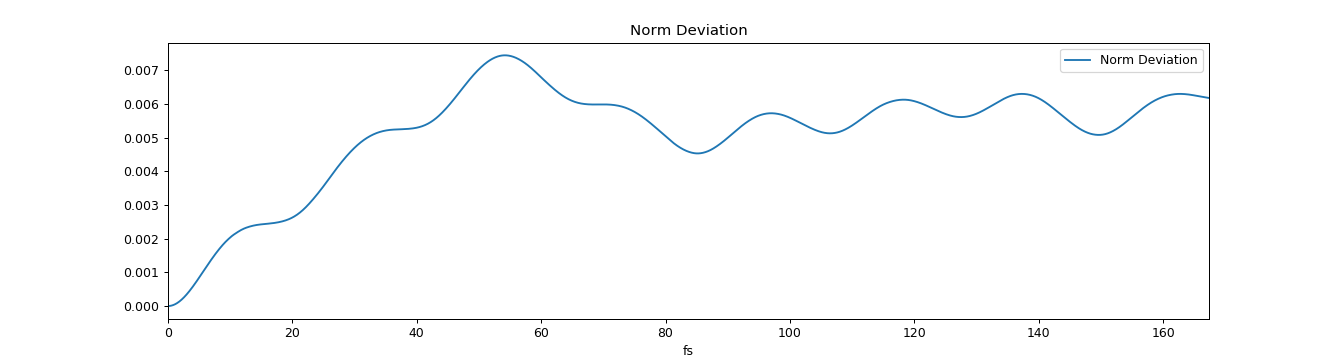

<IPython.core.display.Javascript object>


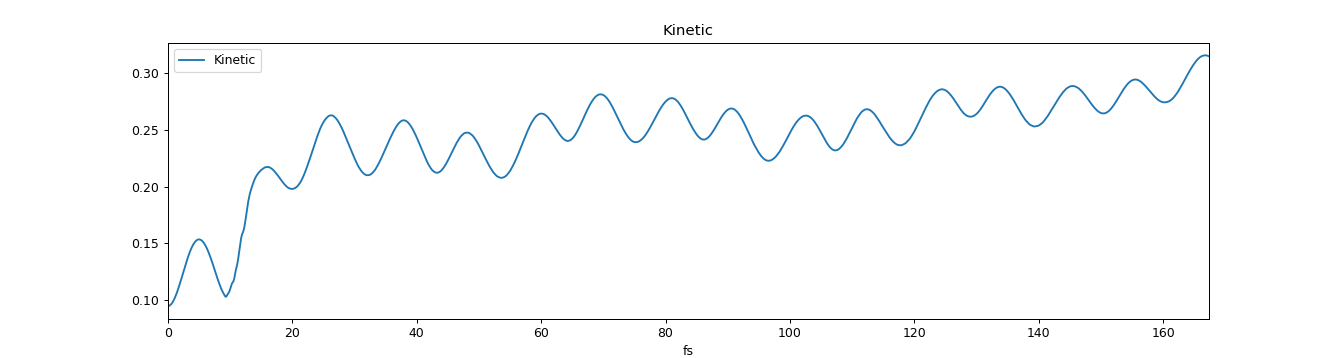

<IPython.core.display.Javascript object>


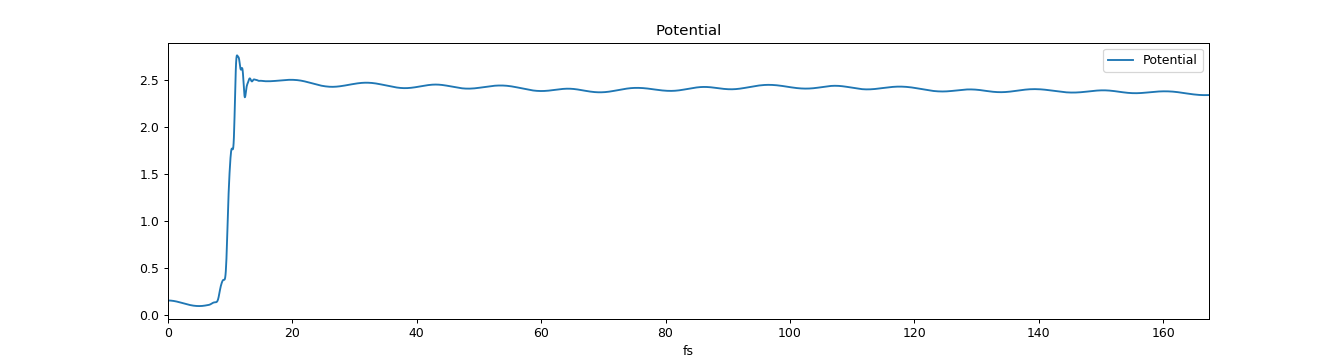

<IPython.core.display.Javascript object>


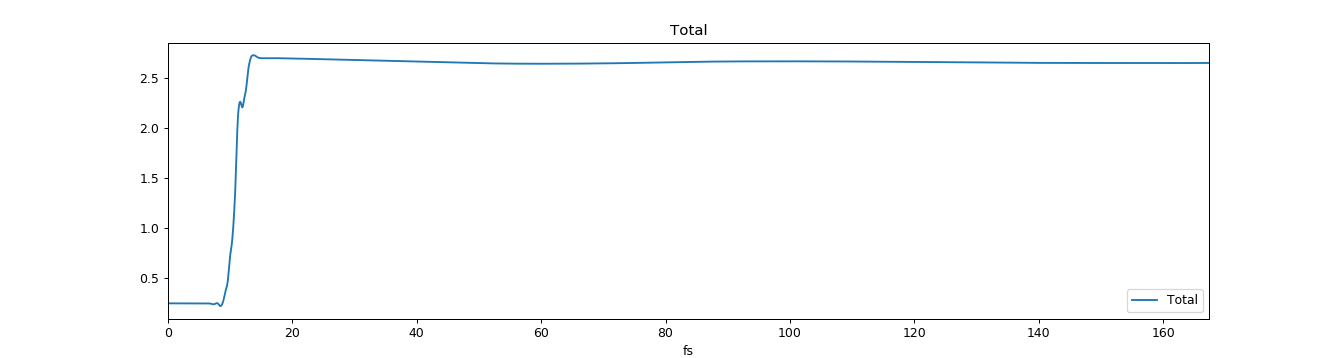

In [24]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4))
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

<IPython.core.display.Javascript object>


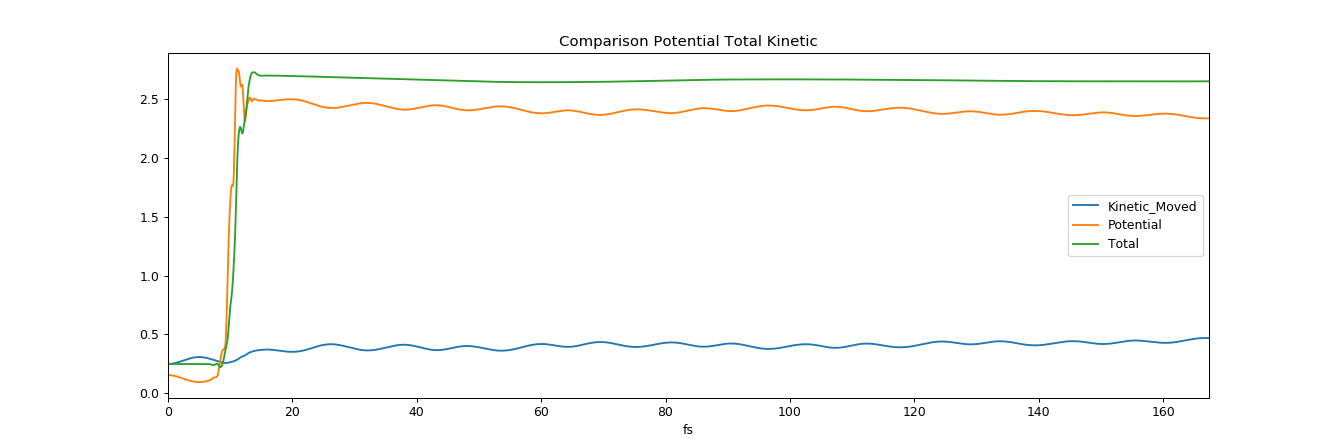

In [25]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

<IPython.core.display.Javascript object>


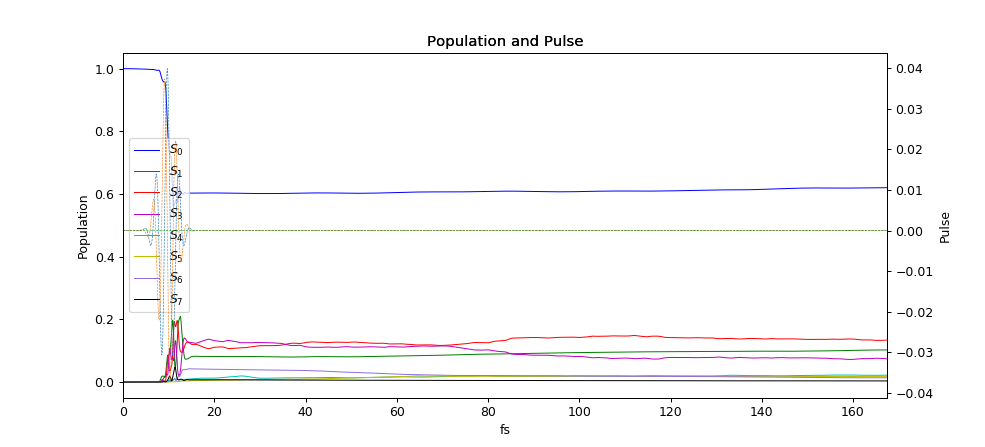

In [26]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')

rename_dict = {}
for i in range(nstates):
    rename_dict[i+1] = r"$S_{}$".format(i)
    
popul = [rename_dict[i+1] for i in range(nstates)]

result2 = result.rename(index=str, columns=rename_dict)

colors = ['b', 'g', 'r', 'm', 'c', 'y', 'mediumpurple', 'k']

# with new names
result2.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'], y=popul, linewidth=0.8, color = colors)
result2.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'], y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--',legend=False);

In [112]:
# fig = plt.figure(figsize=(13,8))

# ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6],xticklabels=[])
# ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])

# ax1.set_ylabel('Population')

# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']

# x1 = result['fs'][:200]
# for i in np.arange(nstates):
#     y1 = result[i+1][:200]
#     col = colors[i]
#     laby = r'$S_{{{}}}$'.format(i)
#     ax1.plot(x1,y1,color=col, label=laby)

# ax2.set_ylabel('Pulse (eV)')

# y2 = result['Xpulse'][:200]
# ax2.set_xlabel('fs')
# ax2.plot(x1,y2)
# ax1.legend()

# plt.savefig('vediamo.svg')

# plt.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
# result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected values

In [27]:
def expected(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi: - \n  Theta: - \n  Gamma: -'.format(i, popu**2))
        else:
            wfA = abs2(wfState/popu)
            # We need to sun and then sum again. From 3d to 1d.
            phiAvg = np.sum(np.sum(wfA,axis=2),axis=1)
            gamAvg = np.sum(np.sum(wfA,axis=2),axis=0)
            theAvg = np.sum(np.sum(wfA,axis=1),axis=0)
            phiA = sum([ phis[i] * phiAvg[i] for i in range(phiAvg.size) ])
            gamA = sum([ gams[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thes[i] * theAvg[i] for i in range(theAvg.size) ])
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi:   {:10.3f} \n  Theta: {:10.3f} \n  Gamma: {:10.3f}'.format(i, popu**2, phiA, theA, gamA))

def fexp(frame):
    return expected(frame)

if interactive:
    interact(fexp, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    fexp(0)
    print('Last Step:')
    fexp(lastV)

A Jupyter Widget

## Look at side of cell

In [28]:
def side(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfAB = qp.abs2(wf[:,:,:,i])
        print('State {}:'.format(i))
        print('Phi -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[-1,:,:]),np.sum(wfAB[0,:,:])))
        print('Gam -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,-1,:]),np.sum(wfAB[:,0,:])))
        print('The -> {:5.2e} {:5.2e}\n'.format(np.sum(wfAB[:,:,-1]),np.sum(wfAB[:,:,0])))


def side_f(frame):
    return side(frame)

if interactive:
    interact(side_f, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    side_f(0)
    print('Last Step:')
    side_f(lastV)   

A Jupyter Widget

# REGIONS !!

In [29]:
import pickle
regions_file = '/home/alessio/n-Propagation/regions.pickle'

with open(regions_file, "rb") as input_file:
    cubess = pickle.load(input_file)

regionsN = len(cubess)

In [33]:
regions_vector = np.empty((filesN,regionsN))
fs_vector = np.empty(filesN)

labels_region = []
for r in range(regionsN):
    labels_region.append(cubess[r]['label']) 
    for f in range(filesN):
        if r == 0: # to do this once and not n_region times
            time = alltime[f]
            fs_vector[f] = time
        
        uno = allwf[f,:,:,:,0] # Ground state
        due = cubess[r]['cube'] # yeah, because of time
        value = np.linalg.norm(uno*due)
        regions_vector[f,r] = value   # yes yes, I am swapping because of pandas


<IPython.core.display.Javascript object>


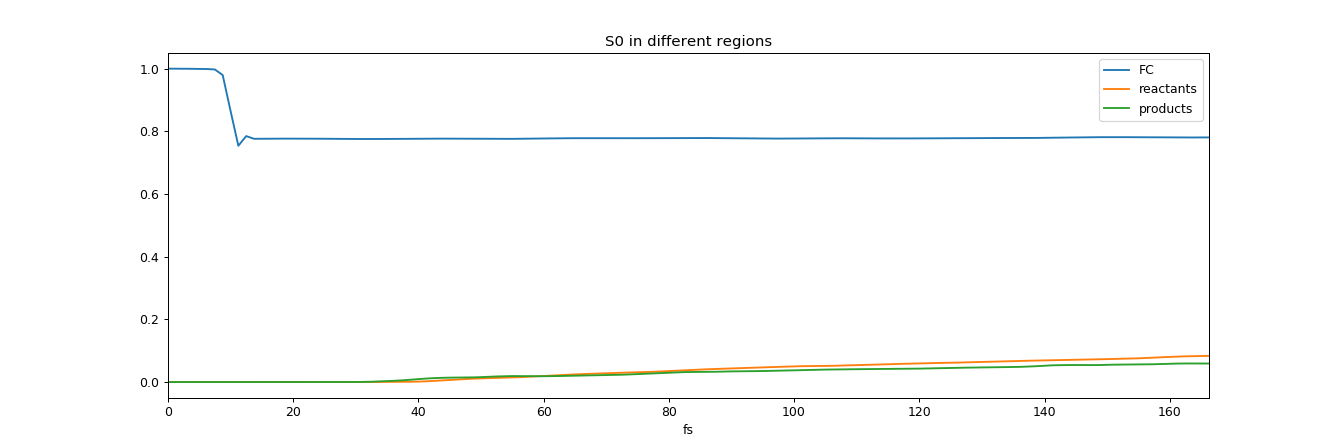

In [34]:
dataf_regions = pd.DataFrame(regions_vector, columns=labels_region)
dataf_regions['fs'] = fs_vector
dataf_regions.plot(figsize=(15,5),title = 'S0 in different regions',x=['fs']);

In [35]:
dataf_regions

,FC,reactants,products,fs
0,1.000000,1.653115e-17,2.913116e-34,0.000000
1,0.999936,2.527861e-11,1.134946e-27,1.250000
2,0.999756,4.587750e-10,1.893755e-23,2.500000
3,0.999485,1.309477e-09,3.158339e-20,3.750000
4,0.999157,1.443724e-09,2.583526e-17,4.999999
5,0.998752,1.048493e-09,2.284379e-15,6.249999
6,0.997348,1.499236e-09,1.176654e-13,7.499999
7,0.979476,3.343194e-09,1.123260e-11,8.749999
8,0.865551,1.071639e-08,1.406360e-10,9.999999
9,0.753929,2.324811e-08,4.862365e-10,11.249999
